In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from pylab import rcParams
RANDOM_SEED = 42
LABELS = ["Normal", "Pathologic"]

In [3]:
data = pd.read_csv('cardio.csv',sep=',')
data.head()

,A,B,C,D,E,F,G,H,I,J,...,M,N,O,P,Q,R,S,T,U,V
0,0.004912,-0.91999,1.87900,-1.63590,3.26820,-0.061401,-0.27829,-1.11200,5.2757,-0.42049,...,-1.4398,1.5797,1.99870,-0.48828,-0.17946,-1.27540,-1.35470,2.28200,-0.49329,0
1,0.004912,-0.91999,2.06460,-1.05250,2.56940,-0.061401,-0.27829,-1.11200,3.5386,-0.42049,...,-1.4398,1.9097,1.65470,-0.48828,-0.17946,-0.82846,-0.73404,1.17980,-0.49329,0
2,0.004912,-0.91999,2.15550,-0.14973,3.92030,-0.061401,-0.27829,-1.35130,6.3181,-0.42049,...,-1.4398,1.9097,1.99870,-0.48828,-0.78062,-1.33920,-1.49270,1.51380,-0.49329,0
3,0.004912,-0.91999,1.66520,-1.15150,2.46770,-0.061401,-0.27829,-0.93254,1.6856,-0.42049,...,-1.4398,1.6347,2.34270,0.96308,-0.17946,-0.57306,-0.45817,0.47842,-0.49329,0
4,-1.053300,-0.91999,0.17574,-0.73680,0.98752,-0.061401,-0.27829,-1.35130,3.4228,-0.42049,...,-1.4398,1.9647,0.96664,-0.48828,-1.02110,-1.27540,-1.35470,0.11102,-0.49329,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1831 entries, 0 to 1830
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1831 non-null   float64
 1   B       1831 non-null   float64
 2   C       1831 non-null   float64
 3   D       1831 non-null   float64
 4   E       1831 non-null   float64
 5   F       1831 non-null   float64
 6   G       1831 non-null   float64
 7   H       1831 non-null   float64
 8   I       1831 non-null   float64
 9   J       1831 non-null   float64
 10  K       1831 non-null   float64
 11  L       1831 non-null   float64
 12  M       1831 non-null   float64
 13  N       1831 non-null   float64
 14  O       1831 non-null   float64
 15  P       1831 non-null   float64
 16  Q       1831 non-null   float64
 17  R       1831 non-null   float64
 18  S       1831 non-null   float64
 19  T       1831 non-null   float64
 20  U       1831 non-null   float64
 21  V       1831 non-null   int64  
dtype

In [16]:
# Coulmn V is the class feature
pathologic = data[data['V']==1]
normal = data[data['V']==0]
outlier_fraction = len(pathologic)/float(len(normal))

In [17]:
print(pathologic.shape,normal.shape)

(176, 22) (1655, 22)


In [18]:
from numpy.random import RandomState
rng = RandomState()

In [19]:
train = data.sample(frac=0.7, random_state=rng)
test = data.loc[~data.index.isin(train.index)]

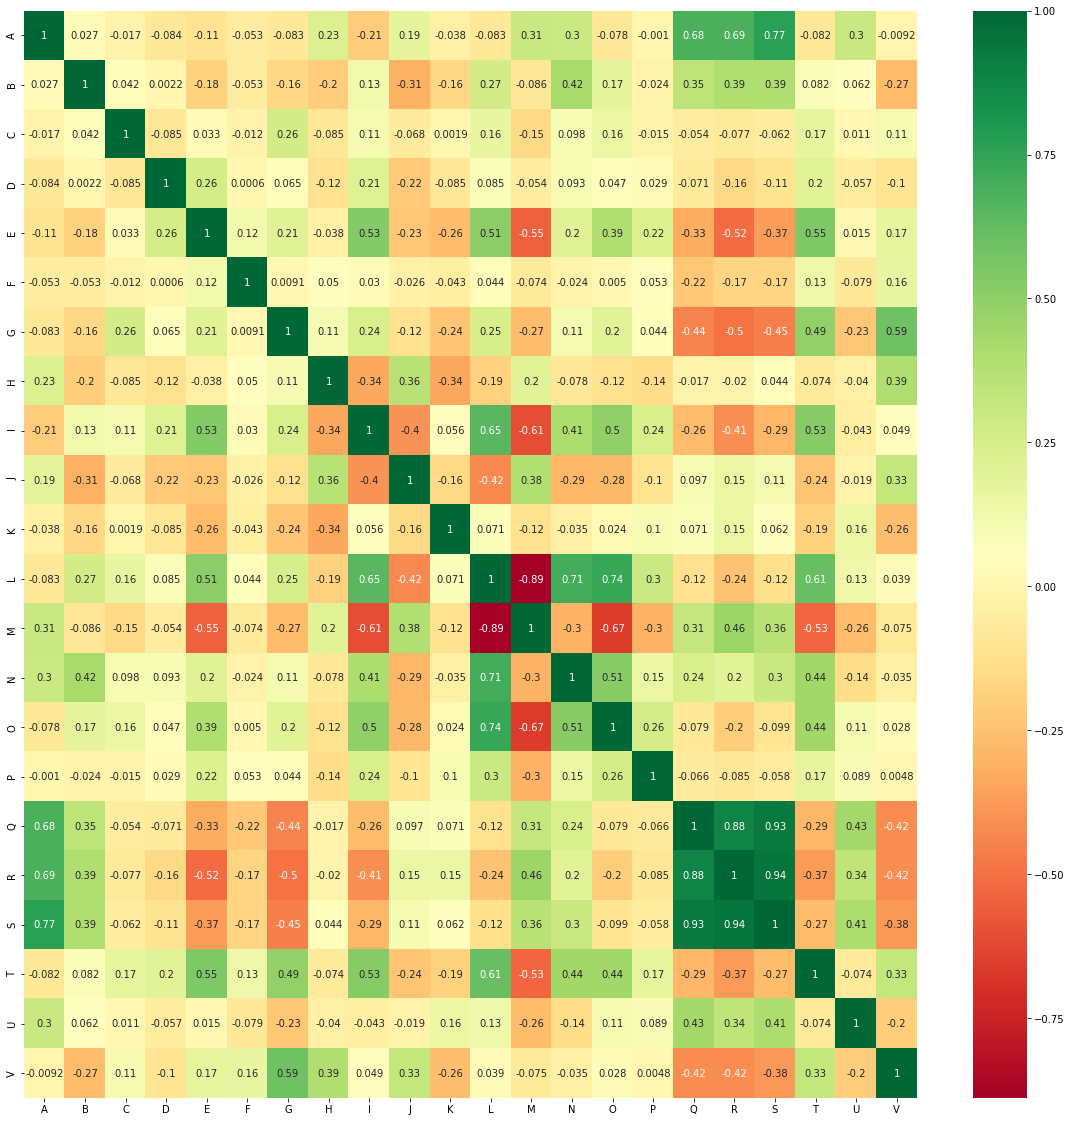

In [20]:
# Correlation
import seaborn as sns
corrmat = train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [55]:
columns = train.columns.tolist() 
columns = [c for c in columns if c not in ["V"]]
target = "V"
state = np.random.RandomState(42)
X = train[columns]
Y = train[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
print(X.shape)
print(Y.shape)

(1282, 21)
(1282,)


In [23]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
   
}

In [24]:
n_outliers = len(pathologic)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 142
Accuracy Score :
0.8892355694227769
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1151
           1       0.46      0.48      0.47       131

    accuracy                           0.89      1282
   macro avg       0.70      0.71      0.70      1282
weighted avg       0.89      0.89      0.89      1282

Local Outlier Factor: 216
Accuracy Score :
0.8315132605304212
Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1151
           1       0.19      0.20      0.19       131

    accuracy                           0.83      1282
   macro avg       0.55      0.55      0.55      1282
weighted avg       0.83      0.83      0.83      1282



In [27]:
columns = test.columns.tolist()
columns = [c for c in columns if c not in ["V"]] 
target = "V"
state = np.random.RandomState(42)
A = test[columns]
B = test[target]
A_outliers = state.uniform(low=0, high=1, size=(A.shape[0], A.shape[1]))
print(A.shape)
print(B.shape)

(549, 21)
(549,)


In [28]:
# Picking Isolation Forest because of   betteranamoly prediction accuracy
classifier=IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0)

In [56]:
classifier.fit(X)
B_pred = classifier.predict(A)
B_pred[B_pred == 1] = 0
B_pred[B_pred == -1] = 1
Count = (B_pred == 1).sum()
print('Pathologic predictions:'+ str(Count))
print('Accuracy Score :'+ str(accuracy_score(B,B_pred)))

Pathologic predictions:62
Accuracy Score :0.8998178506375227
